This code will detect vacuoles within an image. 


input: micrgraph with many vacuoles
output: enhance contrast image
        coordinates of every vacuole and their relative radii
        

In [53]:
#Get a bunch of functions

import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage import data, img_as_float
from skimage import exposure
from skimage import filters
from scipy import ndimage as ndi
from math import sqrt
from skimage import feature
from skimage.feature import blob_dog
from skimage import draw
from skimage import morphology

(1200, 1920)

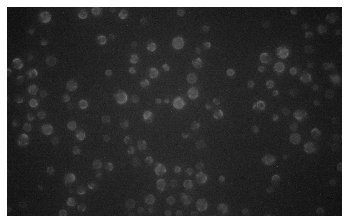

In [54]:
#Import image 
im1 = io.imread("IM1.ome.png")
im = img_as_float(im1) #adjust so all pixel values are scaled between 0 and 1

plt.imshow(im, cmap='gray')
plt.axis('off')
im.shape

(-0.5, 1919.5, 1199.5, -0.5)

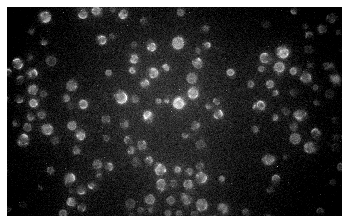

In [55]:
# Enhance contrast - stretching method 
# My understanding is that this is still a linear change in contrast
# I chose these values based on this image. Will need to see how it does on other ones. 

p_low, p_high = np.percentile(im, (18,99.99))
im_rescale = exposure.rescale_intensity(im, in_range=(p_low, p_high))

plt.imshow(im_rescale, cmap='gray')
plt.axis('off')

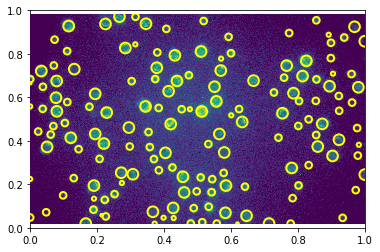

In [58]:
blobs_dog = blob_dog(im_rescale, min_sigma=.95, max_sigma=30, threshold=.2)
blobs_dog[:, 2] = blobs_dog[:, 2] * 1.2 #if we want to include a slightly larger radius. 

fig, axes = plt.subplots(1, 1)

ax = fig.add_subplot(1, 1, 1)

for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax.add_patch(c)
    
plt.axis('off')
plt.imshow(im_rescale)
plt.show()

In [59]:
# read in original image, this is so that our mask turns out the same size
image = im_rescale

# create the mask image
mask = np.ones(shape=image.shape[0:2], dtype="bool")

for blob in blobs_dog:
    y, x, r = blob
    # taking the coordinates from the blob detection, draw circles on mask
    rr, cc = draw.circle(y, x, r, shape=image.shape[0:2])
    mask[rr, cc] = False

#plt.imshow(mask, cmap='gray')
#plt.axis('off')

(-0.5, 1919.5, 1199.5, -0.5)

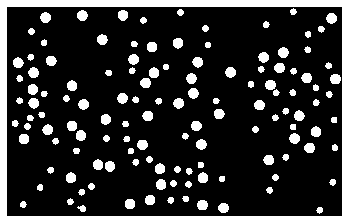

In [60]:
from skimage.util import invert
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border

mask1 = invert(mask)
mask2 = remove_small_objects(mask1, min_size=1000)
mask3 = clear_border(mask2)

plt.imshow(mask3, cmap='gray')
plt.axis('off')

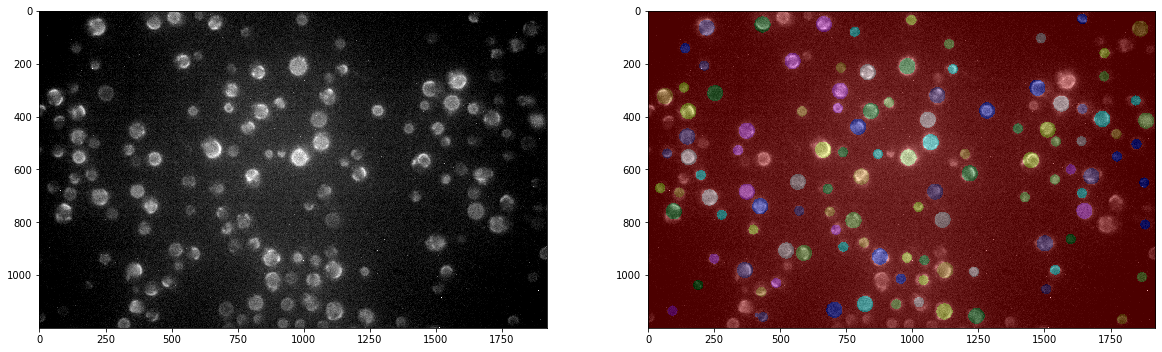

In [61]:
from scipy.ndimage import label
from skimage.color import label2rgb

labeled_vacuoles, _ = label(mask3) 
image_label_overlay = label2rgb(labeled_vacuoles, image=im_rescale)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(im_rescale, cmap='gray')
axes[1].imshow(image_label_overlay, cmap='gray')

In [62]:
from skimage import measure
from skimage.measure import regionprops
from skimage.measure import regionprops_table 

In [63]:
props = ('area', 'major_axis_length', 'minor_axis_length', 'mean_intensity')
regions = pd.DataFrame(regionprops_table(labeled_vacuoles, im_rescale, props))

In [64]:
reg = regionprops_table(labeled_vacuoles, intensity_image=im_rescale, properties=('label', 'mean_intensity'), cache=True, separator='-')

In [65]:
pd.DataFrame(reg)

,label,mean_intensity
0,1,0.242194
1,2,0.356071
2,3,0.430621
3,4,0.381697
4,5,0.474644
...,...,...
121,122,0.425314
122,123,0.058369
123,124,0.351043
124,125,0.281567


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a182fda50>]],
      dtype=object)

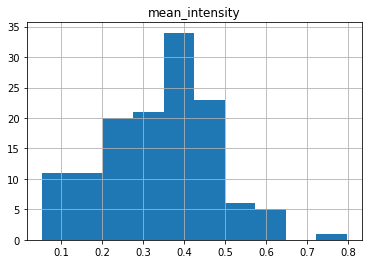

In [13]:
regions.hist(column='mean_intensity')

In [70]:
reg1 = regionprops_table(labeled_vacuoles, intensity_image=im_rescale, properties=('label', 'intensity_image'), separator='-')

In [71]:
pd.DataFrame(reg1)

,label,intensity_image
0,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...
121,122,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
122,123,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
123,124,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
124,125,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [73]:
props = ('intensity_image', 'mean_intensity')
region = pd.DataFrame(regionprops_table(labeled_vacuoles, im_rescale, props))


for prop in region:
    print(prop, region[prop])

intensity_image 0      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                             ...                        
121    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
122    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
123    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
124    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
125    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: intensity_image, Length: 126, dtype: object
mean_intensity 0      0.242194
1      0.356071
2      0.430621
3      0.381697
4      0.474644
         ...   
121    0.425314
122    0.058369
123    0.351043
124    0.281567
125    0.137706
Name: mean_intensity, Length: 126, dtype: float64


In [77]:
t.StandardDeviation = np.std(reg1.intensity_image)

AttributeError: 'dict' object has no attribute 'intensity_image'